In [1]:
'''!pip install pandas scikit-learn flask fastapi uvicorn'''

'!pip install pandas scikit-learn flask fastapi uvicorn'

## Importing Required Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

import warnings
warnings.filterwarnings("ignore")

In [4]:
## loading dataset
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame

In [5]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [7]:
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

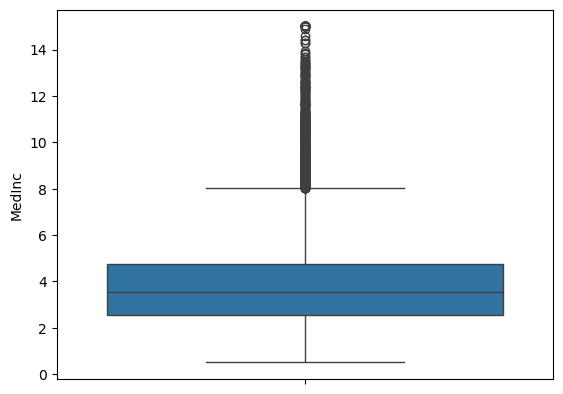

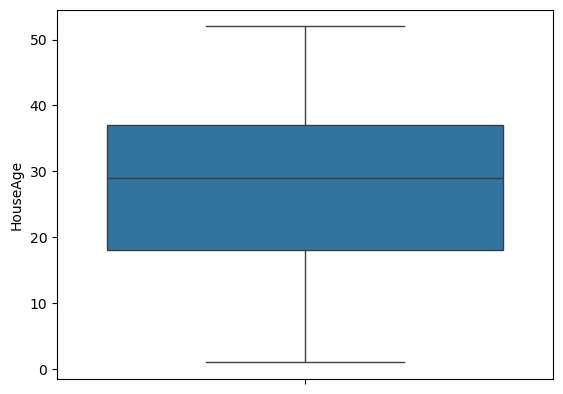

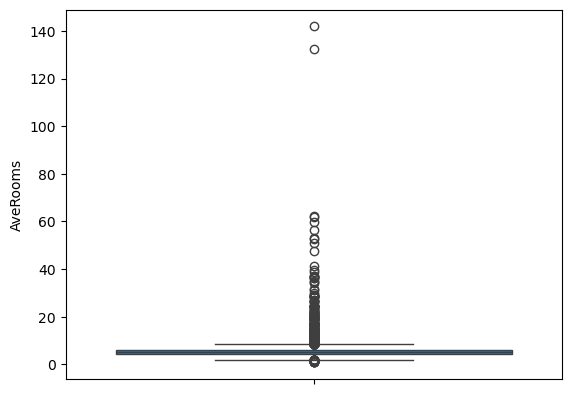

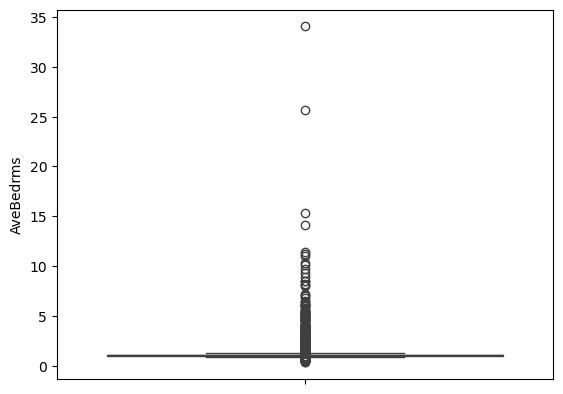

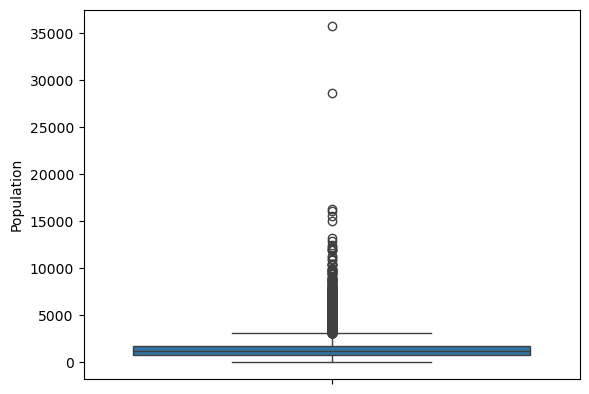

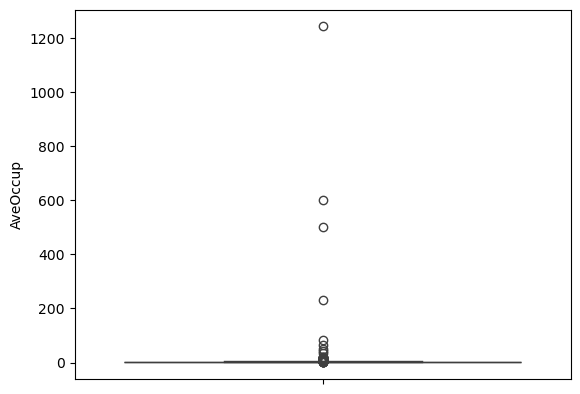

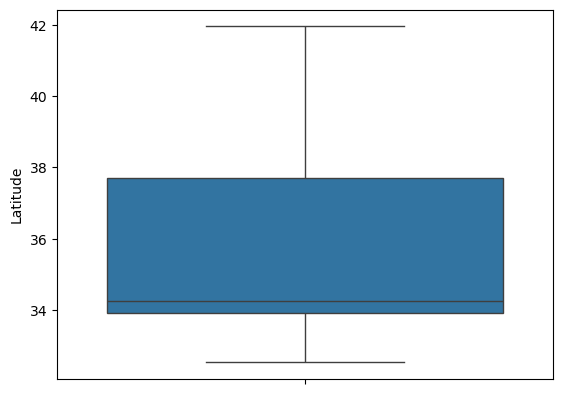

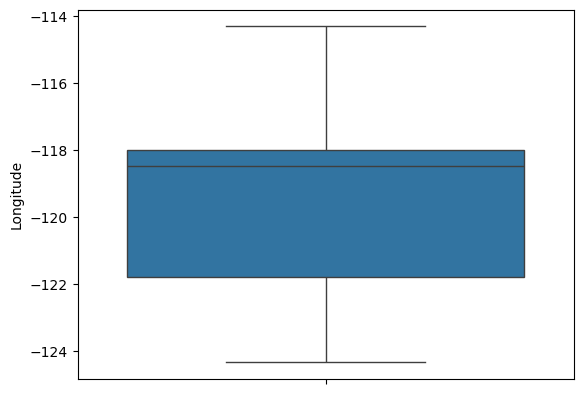

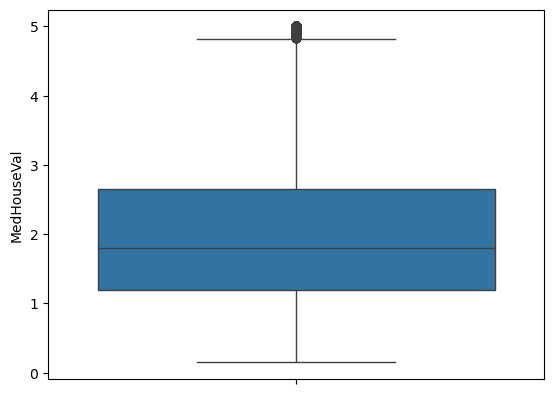

In [8]:
for i in df.columns:
    sns.boxplot(df[i])
    plt.show()

#### - No categorical value
#### - No missing Values
#### - Presence of outliers

In [10]:
## Treating outliers using IQR method
for i in df.columns:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1

    outliers = df[(df[i] < Q1 - 1.5 * IQR) | (df[i] > Q3 + 1.5 * IQR)]
    upper_limit = df[i].quantile(0.95)
    lower_limit = df[i].quantile(0.05)

    df[i] = np.where(df[i] > upper_limit, upper_limit,
                              np.where(df[i] < lower_limit, lower_limit, df[i]))
print("Outliers:\n", outliers)


Outliers:
          MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
89     1.600570      52.0  3.432330   0.939109       396.0  4.333417   
140    6.362400      30.0  5.615385   0.939109       348.0  2.423077   
459    1.600570      52.0  3.432330   0.944000      1349.0  4.333417   
489    3.041700      48.0  4.690632   1.126362      1656.0  3.607843   
493    7.300305      52.0  7.640247   1.051402       517.0  2.415888   
...         ...       ...       ...        ...         ...       ...   
20422  5.145700      35.0  6.958333   1.217593       576.0  2.666667   
20426  7.300305      11.0  7.640247   1.159664       415.0  3.487395   
20427  7.300305       8.0  7.236059   1.032528      3288.0  2.553439   
20436  7.300305      10.0  7.640247   1.102426      1179.0  3.177898   
20443  3.343800      50.0  5.342857   0.942857       348.0  3.714286   

       Latitude  Longitude  MedHouseVal  
89        37.80    -122.27      5.00001  
140       37.81    -122.18      4.83300 

## EDA

In [12]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.787417,28.769186,5.300188,1.061448,1352.935465,2.900210,35.588972,-119.569127,2.068852
std,1.562740,12.350935,1.135382,0.081862,775.085867,0.651988,2.035813,1.930985,1.134517
min,1.600570,8.000000,3.432330,0.939109,348.000000,1.872545,32.820000,-122.470000,0.662000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,7.300305,52.000000,7.640247,1.273006,3288.000000,4.333417,38.960000,-117.080000,4.898100


In [13]:
def histplot(col):
    plt.figure(figsize=(12, 5))
    sns.histplot(df[col], kde = True, bins = 50, stat = 'probability')
    plt.title(f"{col} histogram distribution")


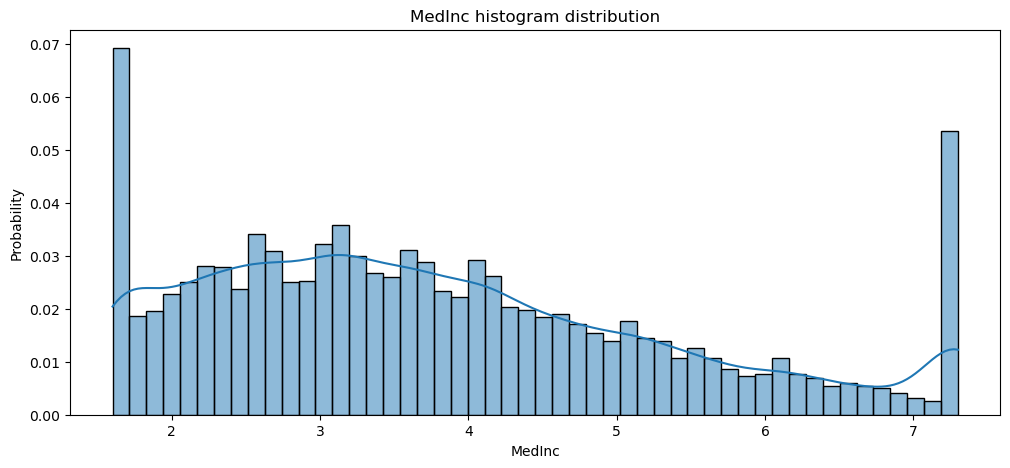

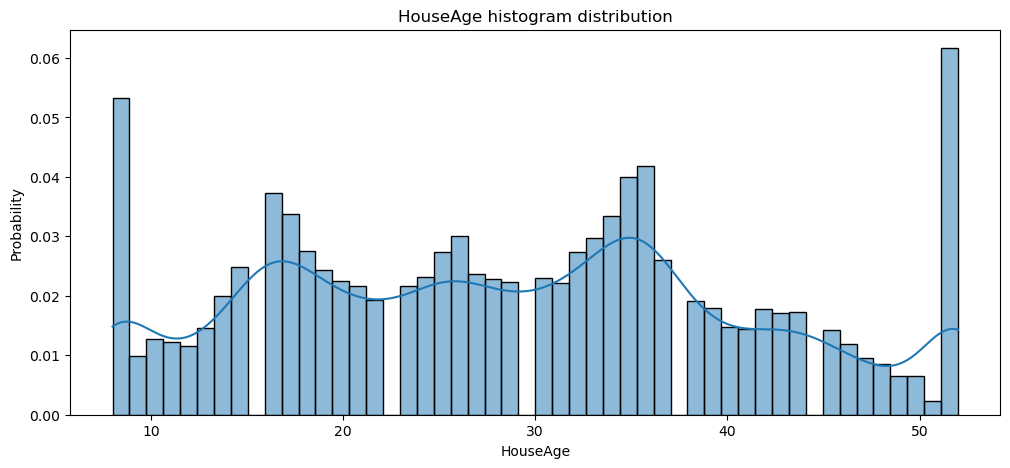

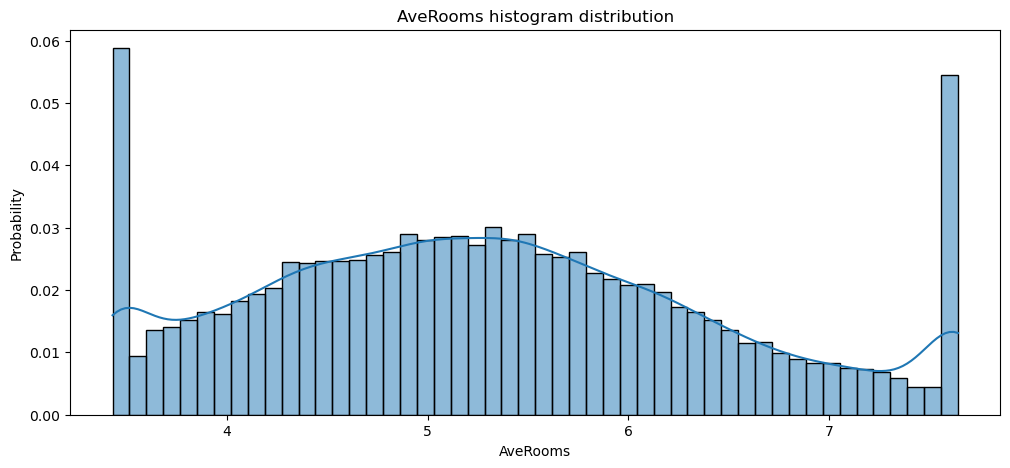

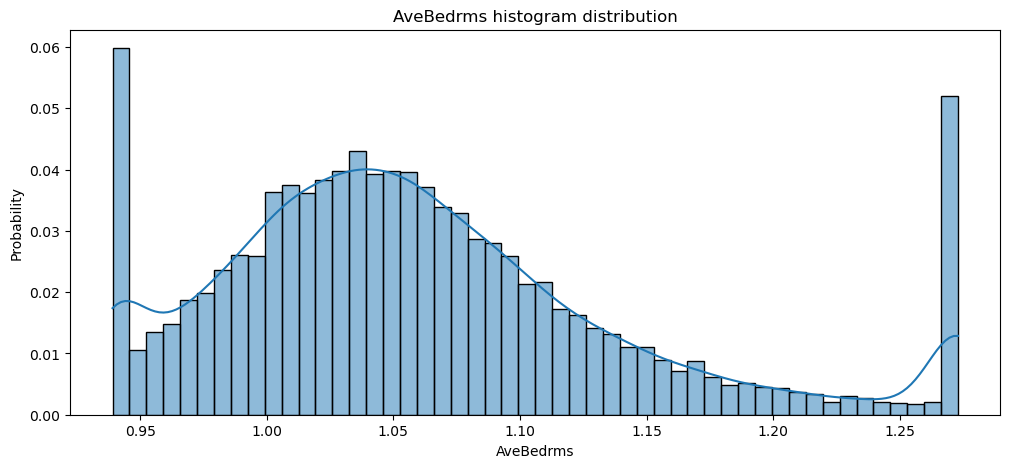

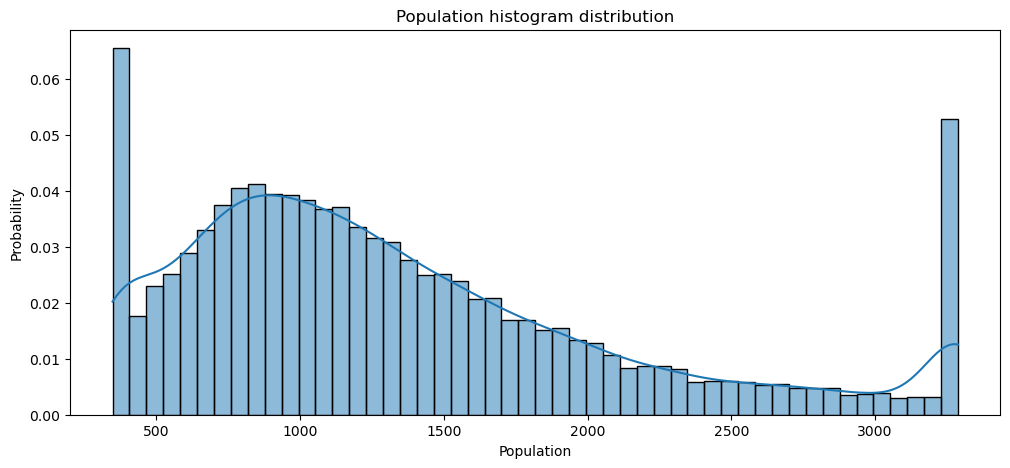

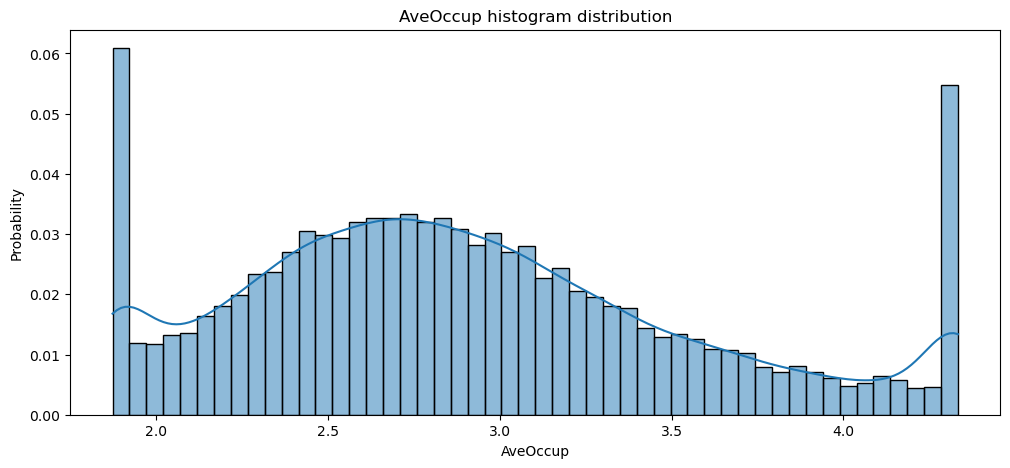

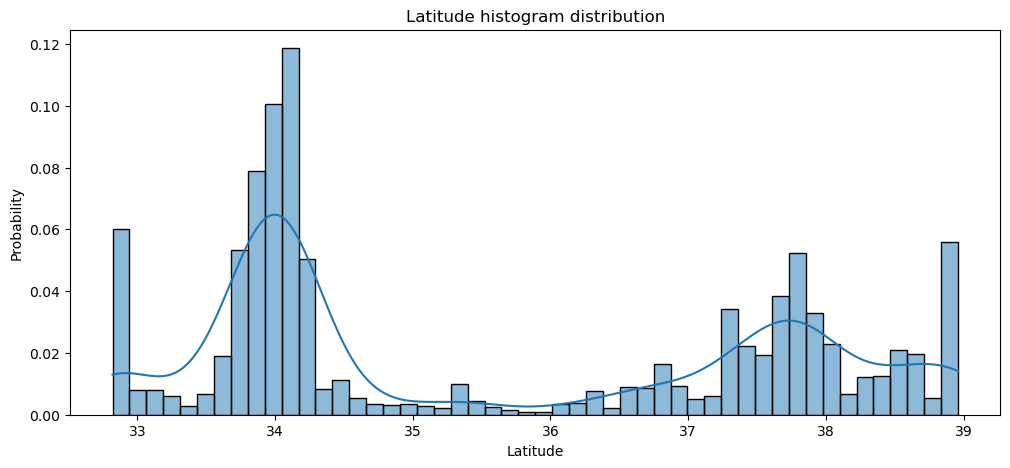

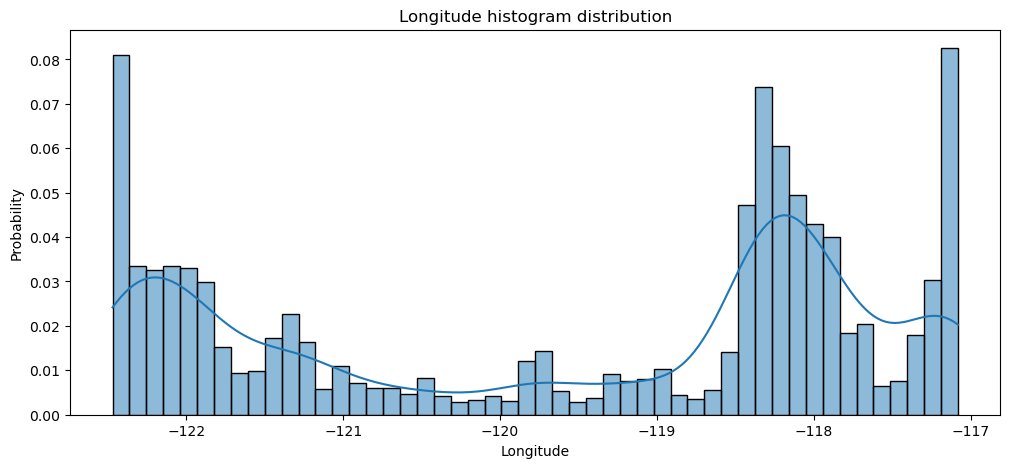

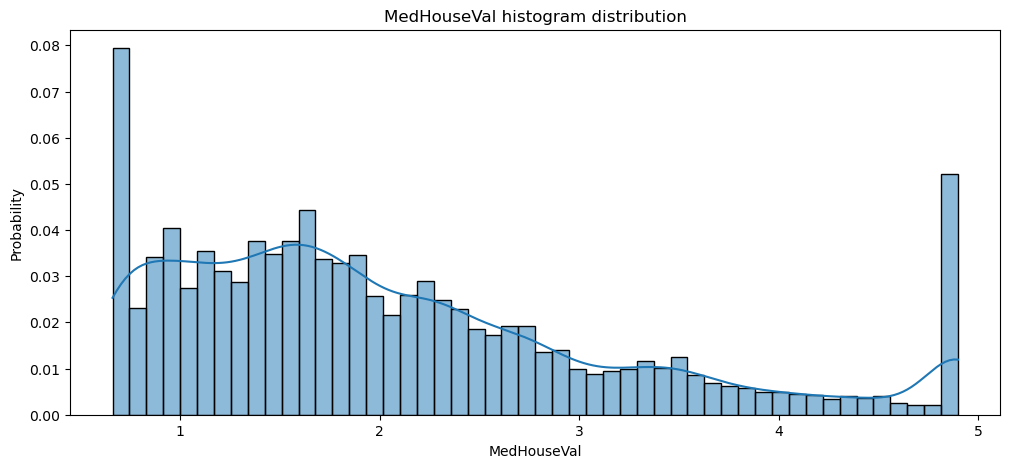

In [14]:
for i in df.columns:
    histplot(i)

<Axes: ylabel='MedHouseVal'>

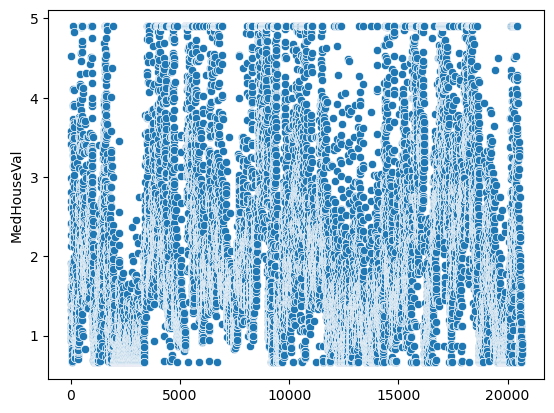

In [15]:
sns.scatterplot(df['MedHouseVal'])

## Train-test split

In [17]:
x = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Model Trainning

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [19]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor())
])

# Model training
pipelines = {
    'Linear Regression': pipeline_lr,
    'Decision Tree': pipeline_dt,
    'Random Forest': pipeline_rf,
    'XGBoost': pipeline_xgb
}

# Fit and evaluate each model
for name, pipe in pipelines.items():
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    print(f"{name} - RMSE: {mean_squared_error(y_test, y_pred):.4f}")




voting_regressor = VotingRegressor([
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor()),

])

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', voting_regressor)
])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

print("Voting Regressor RMSE:", mean_squared_error(y_test, y_pred))



stacking_regressor = StackingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor())
    ],
    final_estimator=RandomForestRegressor()
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', stacking_regressor)
])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

print("Stacking Regressor RMSE:", mean_squared_error(y_test, y_pred))

Linear Regression - RMSE: 0.4549
Decision Tree - RMSE: 0.5049
Random Forest - RMSE: 0.2543
XGBoost - RMSE: 0.2213
Voting Regressor RMSE: 0.30366400909603036
Stacking Regressor RMSE: 0.4115752748671454


## Hyperparameter Tunning

In [20]:
'''from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Define models
class_model = {
    'dtree': DecisionTreeRegressor(),
    'rfr': RandomForestRegressor(),
    'xgb': XGBRegressor(),
    'lr': LinearRegression(),
    'voting': VotingRegressor([
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('rf', RandomForestRegressor())
    ])
}

# Define hyperparameters
class_hyperparams = {
    'dtree': {
        'dtree__criterion': ['squared_error', 'absolute_error'],
        'dtree__splitter': ['best', 'random'],
        'dtree__max_depth': [None, 10, 20, 30],
        'dtree__min_samples_split': [2, 5, 10],
        'dtree__min_samples_leaf': [1, 2, 5],
        'dtree__max_features': [None, 'sqrt', 'log2']
    },
    'rfr': {
        'rfr__n_estimators': [100, 200, 300],
        'rfr__max_depth': [None, 10, 12, 14],
        'rfr__min_samples_split': [2, 5, 10],
        'rfr__min_samples_leaf': [1, 2, 5],
        'rfr__max_features': [None, 'sqrt', 'log2']
    },
    'xgb': {
        'xgb__n_estimators': [100, 300, 400],
        'xgb__max_depth': [3, 6, 10],
        'xgb__learning_rate': [0.005, 0.007, 0.008],
        'xgb__subsample': [0.8, 0.9, 1.0],
        'xgb__colsample_bytree': [0.8, 0.9, 1.0]
    },
    'voting': {}
}

# Hyperparameter tuning
for cl_name, cls in class_model.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (cl_name, cls)
    ])

    class_hyperparam = class_hyperparams.get(cl_name, {})

    random_search_model = RandomizedSearchCV(
        pipeline, class_hyperparam, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
    )

    random_search_model.fit(x_train, y_train)

    print("-------" * 9)
    print(f"Best parameters for {cl_name}: {random_search_model.best_params_}")

    y_pred_train = random_search_model.predict(x_train)
    y_pred_test = random_search_model.predict(x_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f"Mean Absolute Error on train set for {cl_name}: {mae_train:.4f}")
    print(f"Mean Absolute Error on test set for {cl_name}: {mae_test:.4f}")
    print(f"R² score on train set for {cl_name}: {r2_train:.4f}")
    print(f"R² score on test set for {cl_name}: {r2_test:.4f}")
'''

'from sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.ensemble import RandomForestRegressor, VotingRegressor\nfrom sklearn.tree import DecisionTreeRegressor\nfrom xgboost import XGBRegressor\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.metrics import mean_absolute_error, r2_score\nimport numpy as np\n\n# Define models\nclass_model = {\n    \'dtree\': DecisionTreeRegressor(),\n    \'rfr\': RandomForestRegressor(),\n    \'xgb\': XGBRegressor(),\n    \'lr\': LinearRegression(),\n    \'voting\': VotingRegressor([\n        (\'lr\', LinearRegression()),\n        (\'dt\', DecisionTreeRegressor()),\n        (\'rf\', RandomForestRegressor())\n    ])\n}\n\n# Define hyperparameters\nclass_hyperparams = {\n    \'dtree\': {\n        \'dtree__criterion\': [\'squared_error\', \'absolute_error\'],\n        \'dtree__splitter\': [\'best\', \'random\'],\n        \'dtree__max_depth\

## **Best parameters for xgb:**
 {'xgb__subsample': 1.0, 'xgb__n_estimators': 400, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.008, 'xgb__colsample_bytree': 0.9}
- Mean Absolute Error on train set for xgb: 0.1958
- Mean Absolute Error on test set for xgb: 0.3217
- R² score on train set for xgb: 0.9424
- R² score on test set for xgb: 0.8209

In [22]:
xgb_tunned = XGBRegressor(subsample=1.0, n_estimators=400, max_depth=10, learning_rate=0.008, colsample_bytree=0.9)
xgb_tunned.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
y_pred_train_xgbtunned = xgb_tunned.predict(x_train)
y_pred_xgbtunned = xgb_tunned.predict(x_test)

In [37]:
print("XGB_Tunned R2_Score:", r2_score(y_train, y_pred_train_xgbtunned))
print("****"*15)
print("XGB_Tunned R2_Score:", r2_score(y_test, y_pred_xgbtunned) )

XGB_Tunned R2_Score: 0.9417598282479833
************************************************************
XGB_Tunned R2_Score: 0.8173199148917727


## Model Saving

In [23]:
import pickle
with open("model.pkl", 'wb') as file:
    pickle.dump(xgb_tunned, file)

## Model Testing

In [24]:
'''!pip install flask fastapi uvicorn pyngrok'''


In [25]:
'''!ngrok authtoken 2uABw8xS6riZjHcbcrxZYo63Q7r_5CKV8ADuoXa6d4nU2tnnx'''


Authtoken saved to configuration file: C:\Users\DATTA\AppData\Local/ngrok/ngrok.yml


In [27]:
'''import requests

url = "https://3b2d-104-197-175-58.ngrok-free.app/"
response = requests.get(url)

print("Status Code:", response.status_code)
print("Response Text:", response.text)'''

Status Code: 404
Response Text: <!DOCTYPE html>
<html class="h-full" lang="en-US" dir="ltr">
  <head>
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Semibold-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fon

In [29]:
'''## Test the app
import requests

# Your ngrok URL (replace with your printed URL)
url = "https://3b2d-104-197-175-58.ngrok-free.app/"

# Sample data for testing
test_data = {
    "MedInc": 8.3252,
    "HouseAge": 41,
    "AveRooms": 6.984127,
    "AveBedrms": 1.02381,
    "Population": 322,
    "AveOccup": 2.555556,
    "Latitude": 37.88,
    "Longitude": -122.23
}

# Send POST request
response = requests.post(url, json=test_data)

# Display response
print("Status Code:", response.status_code)
print("Response:", response.json())'''


'## Test the app\nimport requests\n\n# Your ngrok URL (replace with your printed URL)\nurl = "https://3b2d-104-197-175-58.ngrok-free.app/"\n\n# Sample data for testing\ntest_data = {\n    "MedInc": 8.3252,\n    "HouseAge": 41,\n    "AveRooms": 6.984127,\n    "AveBedrms": 1.02381,\n    "Population": 322,\n    "AveOccup": 2.555556,\n    "Latitude": 37.88,\n    "Longitude": -122.23\n}\n\n# Send POST request\nresponse = requests.post(url, json=test_data)\n\n# Display response\nprint("Status Code:", response.status_code)\nprint("Response:", response.json())'